In [5]:
import sys
sys.path.append('C:/Users/320060820/experiments/')
import fxp_quantize
import model_data

import keras
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tnrange, tqdm_notebook

# to restart layer numbering
from keras import backend as K
K.clear_session()

In [2]:
def fix_weights_quantization(model, parameters):
    
    for k in parameters.keys():
        model.model = fxp_quantize.quantize_weights(model.model, parameters[k][0], parameters[k][1],
                                                   layer_name=[k])
    return model
    

def brute_force_analysis_weights(model, layer_names, bw_range, f_range, fix_quant=False, parameters=None, 
                         eval_metric='acc_drop'):
    
    if fix_quant and parameters is None:
        raise ValueError('Parameters is empty')
    
    if not isinstance(layer_names, list):
        layer_names = [layer_names]
    
    for i in layer_names:

        scores_matrix = []

        for j in tnrange(len(bw_range), desc=f'BW Layer {i}', leave=False):
            scores_row = []
            
            for k in tqdm_notebook(range(len(f_range)), desc='F', leave=False):

                model.load_model_from_path()

                if fix_quant:
                    #fix quantization for certain layers
                    model = fix_weights_quantization(model, parameters)

                model.model = fxp_quantize.quantize_weights(model.model, bw_range[j], f_range[k],
                                                            layer_name=[i])
                scores_row.append(model.evaluate_accuracy()[1])

            scores_matrix.append(scores_row)

        scores = np.array(scores_matrix)

        if layer_names.index(i) == 0:
            model_scores = scores
        else:
            model_scores = np.dstack((model_scores, scores))
        
        print(f'Layer {i} done.')
        
    model.load_model_from_path()
    s = model.evaluate_accuracy()[1]
    
    if eval_metric == 'acc_drop':
        model_scores = (s - model_scores) / s
        
    elif eval_metric == 'acc_ratio':
        model_scores = model_scores / s
        
    elif eval_metric == 'quant_acc':
        pass
        
    return model_scores

In [6]:
def plot_results(scores, layer_names, rows, columns, figsize, shrink, bw_range, f_range, invert=False, vmax=None, name=None):
    
    plt.rcParams.update({'font.size': 12, 'font.weight':520})
    if len(scores.shape) < 3:
        scores = np.expand_dims(scores, axis=3)
    fig, ax = plt.subplots(rows, columns, figsize=figsize)
    cbar_ax = fig.add_axes([.91, 0.1, .02, 0.8])
    if rows == 1 and columns == 1:
        ax = [ax]
    else:
        ax = ax.flatten()
    vmin = scores.min()
    if vmax is None:
        vmax = scores.max()
    else:
        vmax=vmax
    t = np.arange(0.0, vmax, 0.1).tolist()
    for i in range(scores.shape[2]):
        sns.heatmap(scores[:, :, i], annot=True, fmt='.3f', ax=ax[i], xticklabels=f_range, 
                    yticklabels=bw_range, vmin = vmin, vmax=vmax, cbar_ax=cbar_ax)#, cbar_kws={"ticks":t})
#         sns.heatmap(scores[:, :, i], annot=True, fmt='.2f', vmin=vmin, vmax=vmax, cbar_ax=cbar_ax)
        ax[i].set_xlabel('Fractional offset')
        ax[i].set_ylabel('Bitwidth')
        ax[i].set_title(f'Layer {layer_names[i]}')
        if invert:
            ax[i].invert_yaxis()
    if rows*columns - scores.shape[2] != 0:
        for i in range(1, rows*columns - scores.shape[2] + 1):
            fig.delaxes(ax[-i])
    if name:
        plt.savefig(f'C:/Users/320060820/OneDrive - Philips/Thesis docs/Thesis/Images/Brute force results/{name}.png', 
                    bbox_inches='tight')

In [7]:
# config
save_path = 'C:/Users/320060820/experiments/test_models/'
output_path = 'C:/Users/320060820/experiments/outputs/Brute_Force_Analysis/Weights/Keras_MNIST/'
bw_range = np.arange(1, 11, 1)
f_range = np.arange(1, 11, 1)
layer_names = [f'conv2d_{i}' for i in range(1, 5)] + ['dense_1']
vmax=0.1

# MNIST

## Quantizing Weights

In [5]:
name = 'mnist_keras'
model_path = 'mnist_custom/mnist_keras.h5'

from test_models.mnist_custom import data
_, test_data = data.get_data()

keras_mnist = model_data.Model(name, test_data, path=save_path+model_path)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


### Forward quantization

In [6]:
scores_ = brute_force_analysis_weights(keras_mnist, layer_names, bw_range, f_range)
np.save(output_path + 'scores_1_w', arr=scores_)

Layer conv2d_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_4 done.


Layer dense_1 done.


In [6]:
parameters = {'conv2d_1': [2, 3]}

scores_1_1 = brute_force_analysis_weights(keras_mnist, layer_names[1:], bw_range, f_range,
                                 fix_quant=True, parameters=parameters)
parameters = {'conv2d_1': [3, 4]}
scores_1_2 = brute_force_analysis_weights(keras_mnist, layer_names[1:], bw_range, f_range,
                                 fix_quant=True, parameters=parameters)
parameters = {'conv2d_1': [4, 5]}
scores_1_3 = brute_force_analysis_weights(keras_mnist, layer_names[1:], bw_range, f_range,
                                 fix_quant=True, parameters=parameters)
parameters = {'conv2d_1': [5, 6]}
scores_1_4 = brute_force_analysis_weights(keras_mnist, layer_names[1:], bw_range, f_range,
                                 fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_1_1', scores_1_1)
np.save(output_path + 'scores_1_2', scores_1_2)
np.save(output_path + 'scores_1_3', scores_1_3)
np.save(output_path + 'scores_1_4', scores_1_4)

Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_4 done.


Layer dense_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_4 done.


Layer dense_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_4 done.


Layer dense_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_4 done.


Layer dense_1 done.


In [22]:
parameters = {
    'conv2d_1': [5, 6],
    'conv2d_2': [4, 5]
}
scores_2 = brute_force_analysis_weights(keras_mnist, layer_names[2:], bw_range, f_range,
                                fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_2', arr=scores_2)

Layer conv2d_3 done.


Layer conv2d_4 done.


Layer dense_1 done.


In [24]:
parameters = {
    'conv2d_1': [5, 6],
    'conv2d_2': [4, 5],
    'conv2d_3': [3, 4]
}
scores_3 = brute_force_analysis_weights(keras_mnist, layer_names[3:], bw_range, f_range,
                               fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_3', arr=scores_3)

Layer conv2d_4 done.


Layer dense_1 done.


In [26]:
parameters = {
    'conv2d_1': [5, 6],
    'conv2d_2': [4, 5],
    'conv2d_3': [3, 4],
    'conv2d_4': [3, 5]
}
scores_4 = brute_force_analysis_weights(keras_mnist, layer_names[4:], bw_range, f_range,
                               fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_4', arr=scores_4)

Layer dense_1 done.


In [9]:
# Use this cell to load scores for plotting if scores are already saved
scores_ = np.load(output_path + 'scores_1_w.npy')
# scores_1_1 = np.load(output_path + 'scores_1_1')
# scores_1_2 = np.load(output_path + 'scores_1_2')
# scores_1_3 = np.load(output_path + 'scores_1_3')
# scores_1_4 = np.load(output_path + 'scores_1_4')
# scores_2 = np.load(output_path + 'scores_2')
# scores_3 = np.load(output_path + 'scores_3')
# scores_4 = np.load(output_path + 'scores_4')

In [20]:
keras_mnist.load_model_from_path()
float_act = keras_mnist.get_activation_maps(keras_mnist.x_test[0].reshape(1, 28, 28, 1), 'conv2d_1')
keras_mnist.model = fxp_quantize.quantize_weights(keras_mnist.model, 2, 2, layer_name = ['conv2d_1'])
fxp_act = keras_mnist.get_activation_maps(keras_mnist.x_test[0].reshape(1, 28, 28, 1), 'conv2d_1')

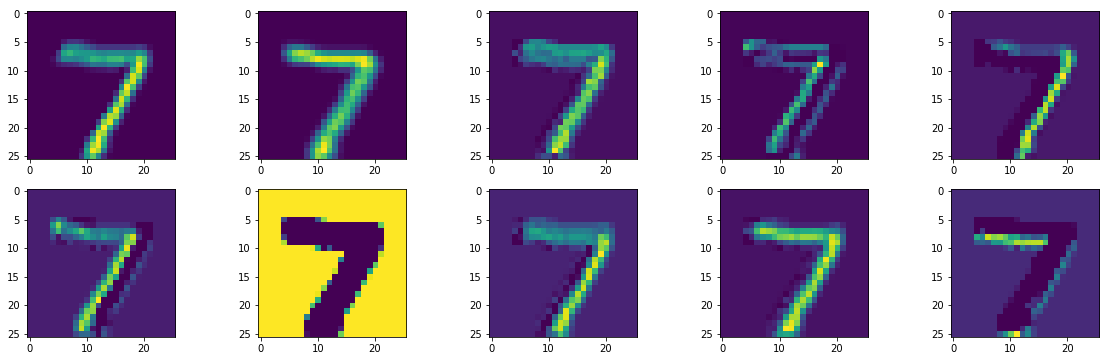

In [24]:
fig, axes = plt.subplots(2, 5, figsize=(20, 6))
ax = axes.flat
for i in range(10):
    ax[i].imshow(float_act[0, :, :, i])

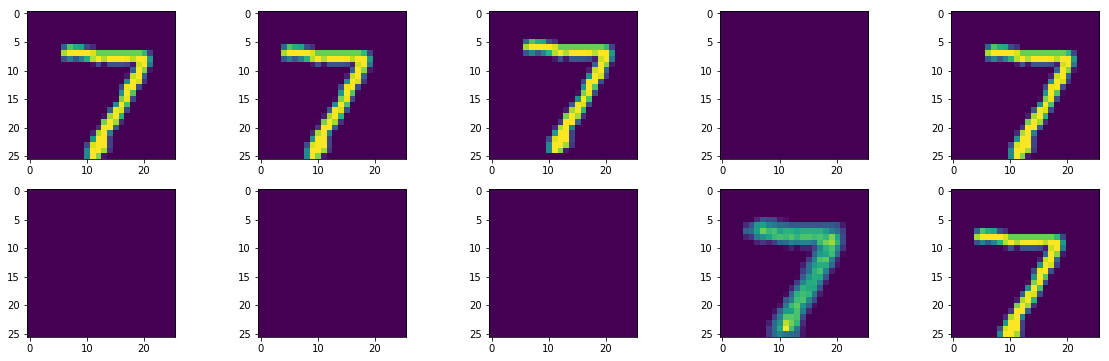

In [25]:
fig, axes = plt.subplots(2, 5, figsize=(20, 6))
ax = axes.flat
for i in range(10):
    ax[i].imshow(fxp_act[0, :, :, i])

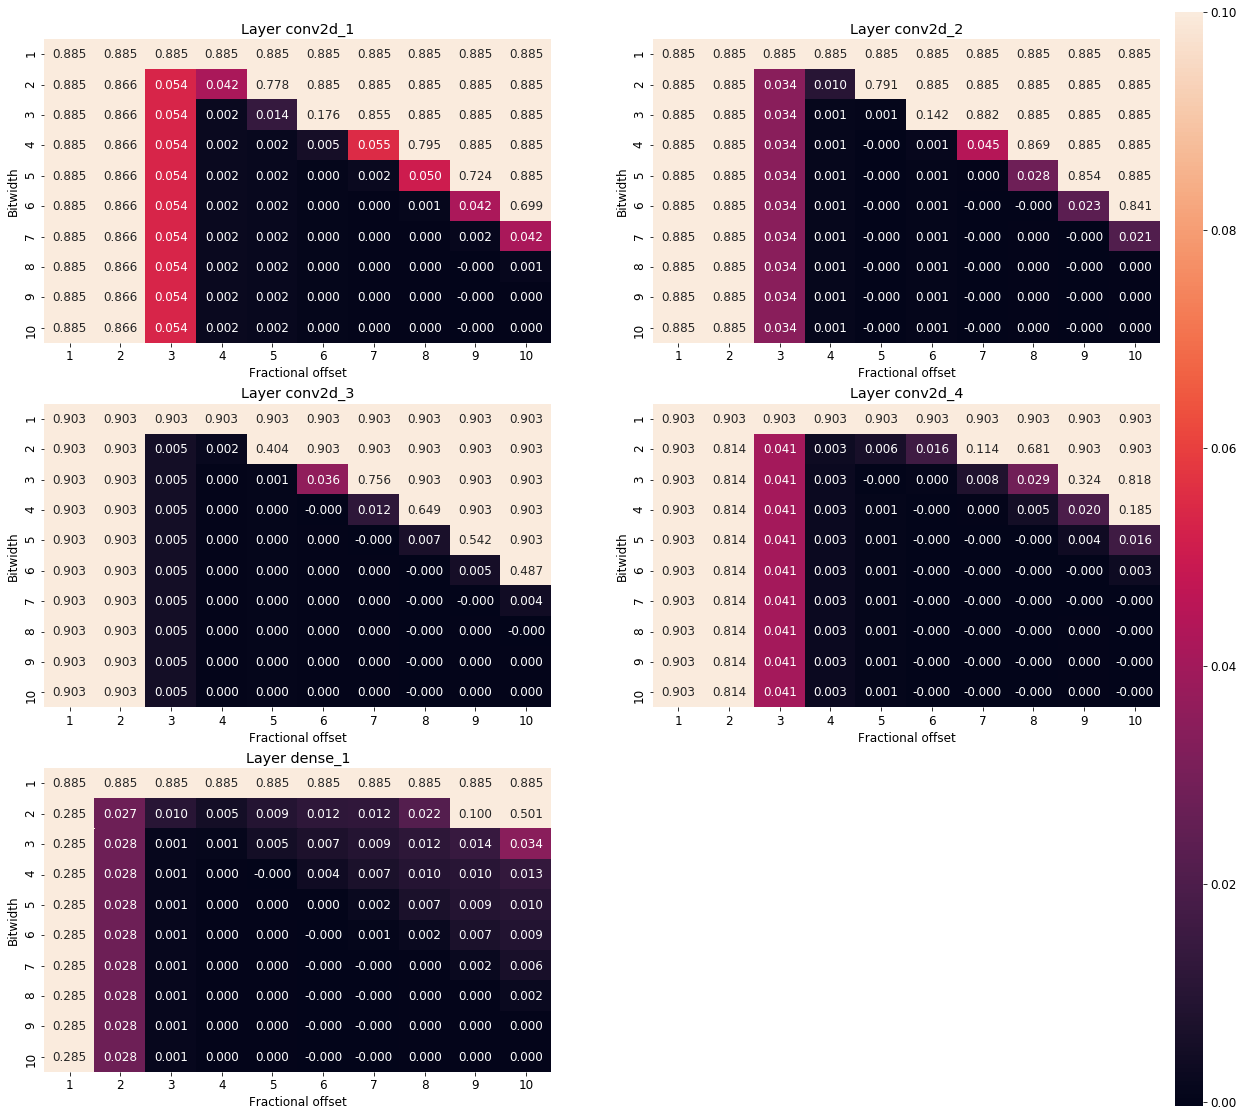

In [11]:
# independent quantization without biases
plot_results(scores_, layer_names, 3, 2, (20, 19), 0.8, bw_range, f_range, vmax=vmax, name='keras_mnist_w')

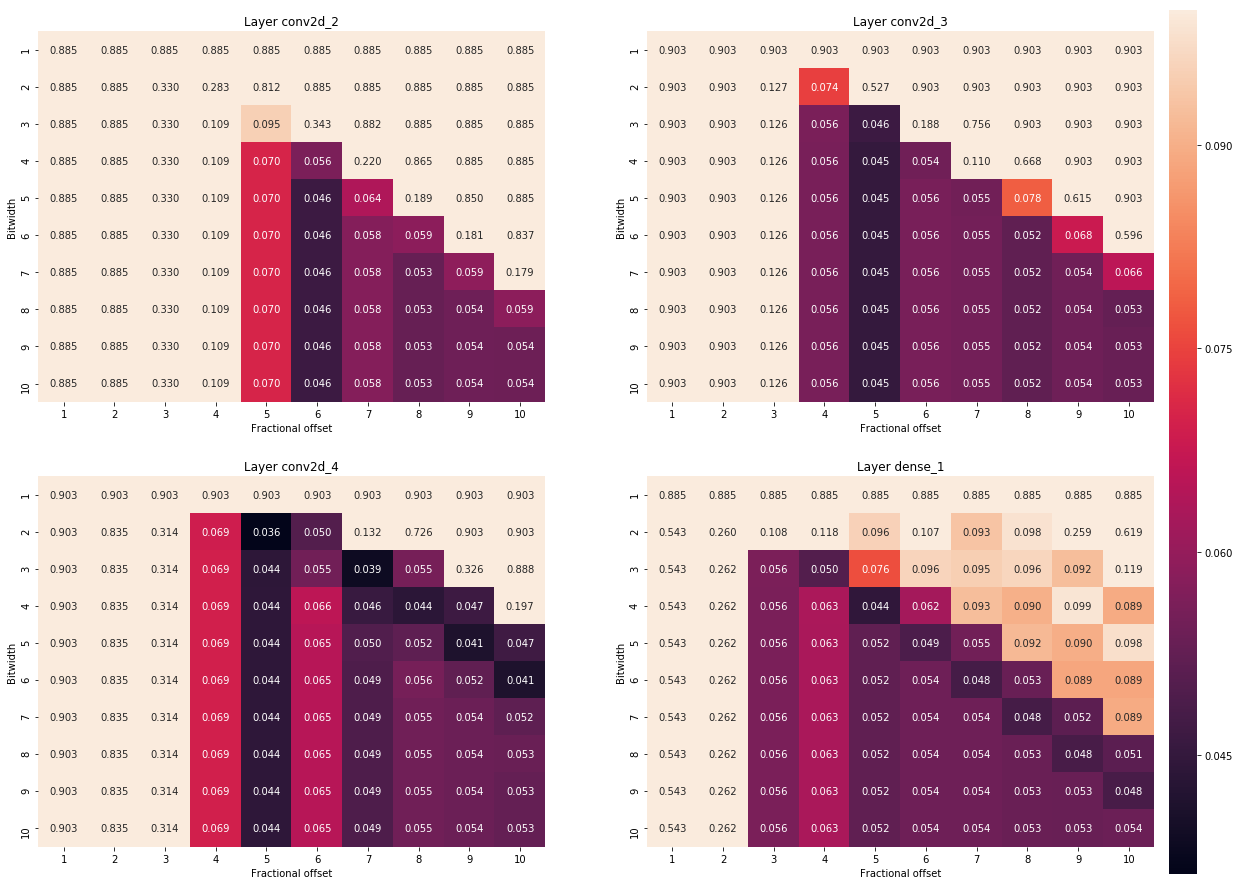

In [11]:
plot_results(scores_1_1, layer_names[1:], 2, 2, (20, 15), 0.8, bw_range, f_range, vmax=vmax)

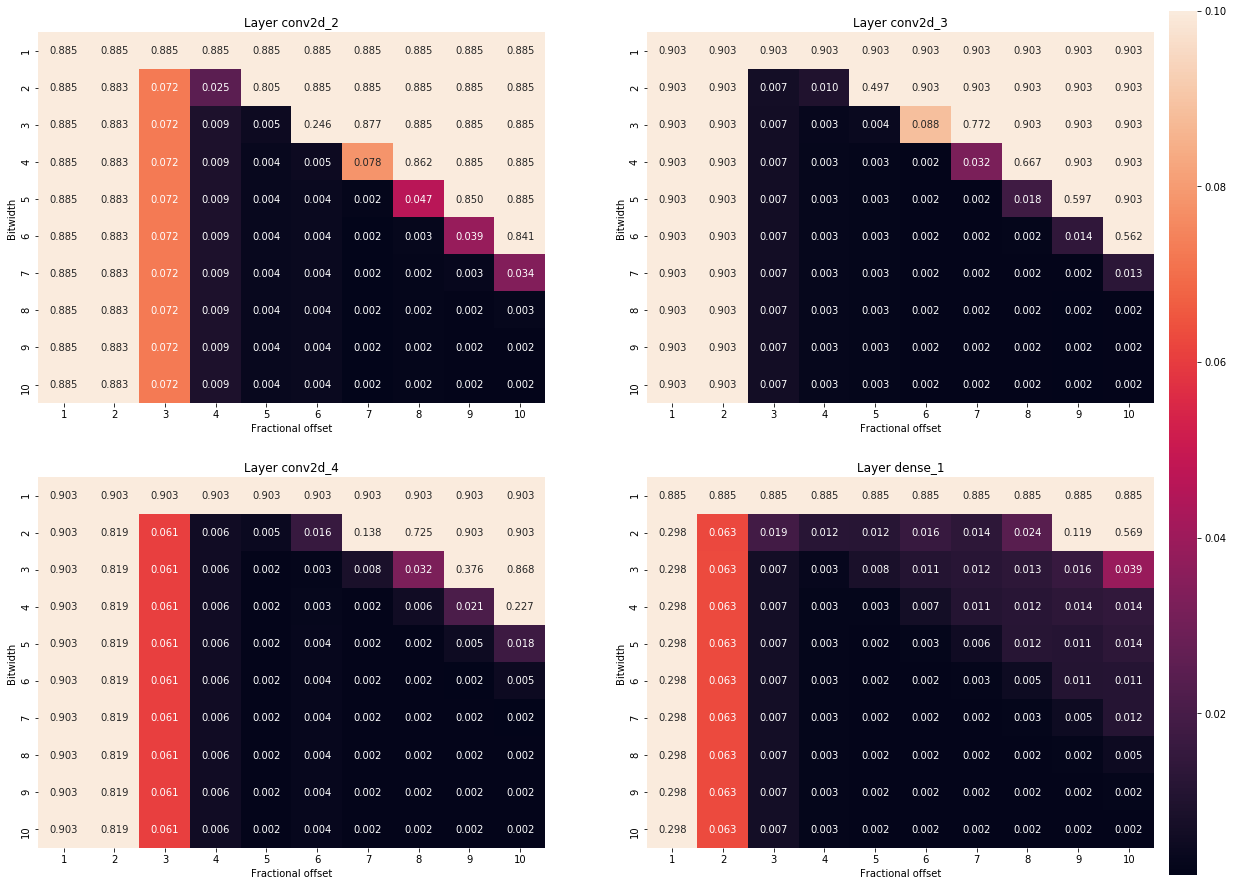

In [10]:
plot_results(scores_1_2, layer_names[1:], 2, 2, (20, 15), 0.8, bw_range, f_range, vmax=vmax)

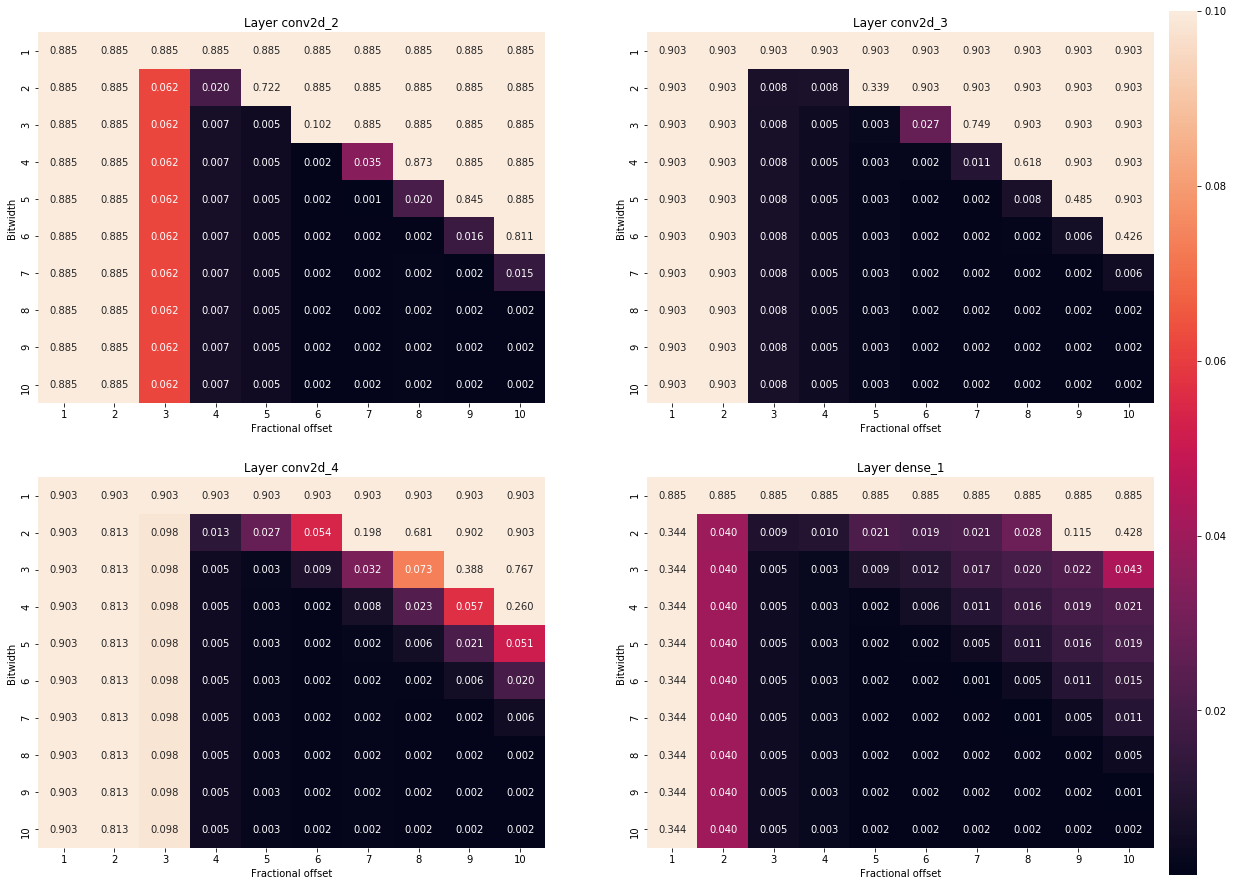

In [11]:
plot_results(scores_1_3, layer_names[1:], 2, 2, (20, 15), 0.8, bw_range, f_range, vmax=vmax)

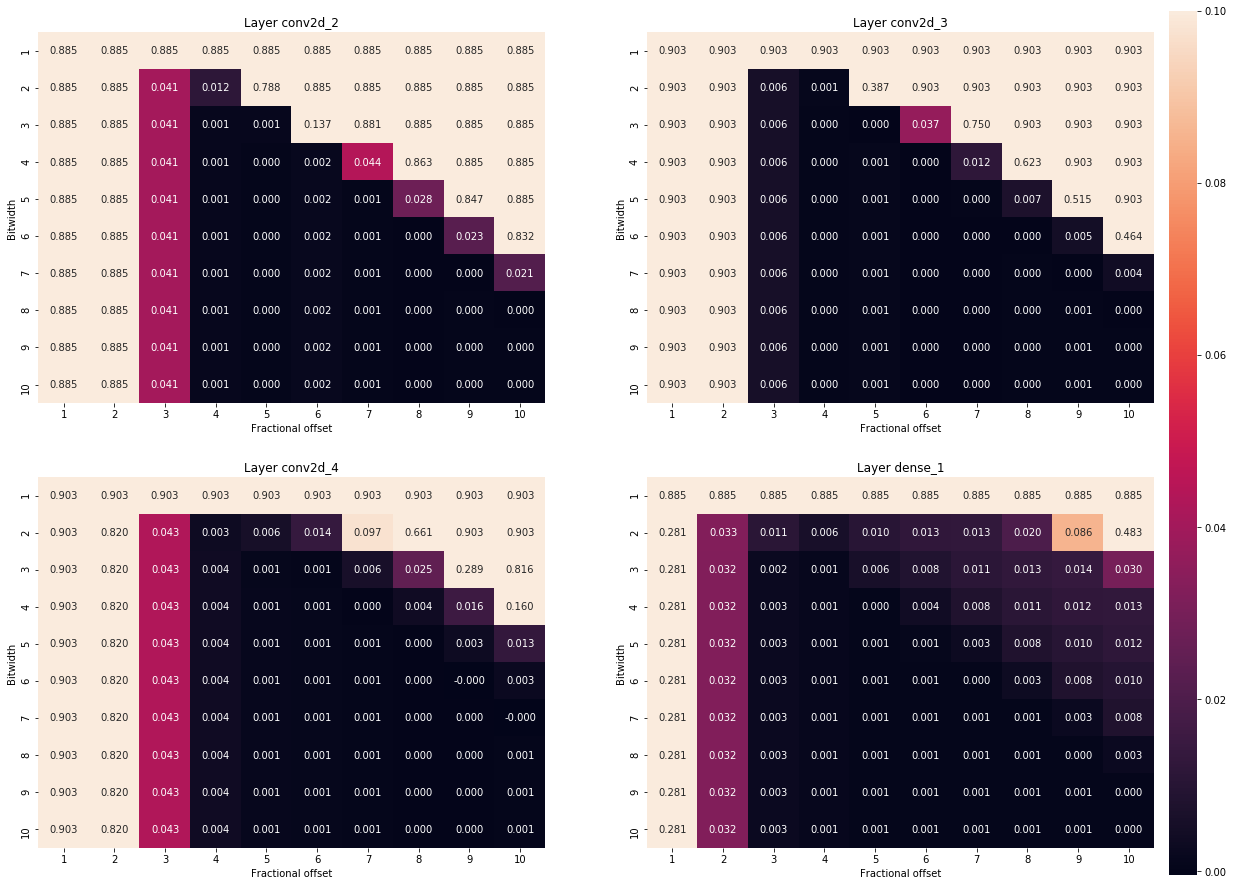

In [12]:
plot_results(scores_1_4, layer_names[1:], 2, 2, (20, 15), 0.8, bw_range, f_range, vmax=vmax)

In [8]:
plot_results(scores_2, layer_names[2:], 2, 2, (20, 15), 0.8, bw_range, f_range, vmax=vmax)

NameError: name 'scores_2' is not defined

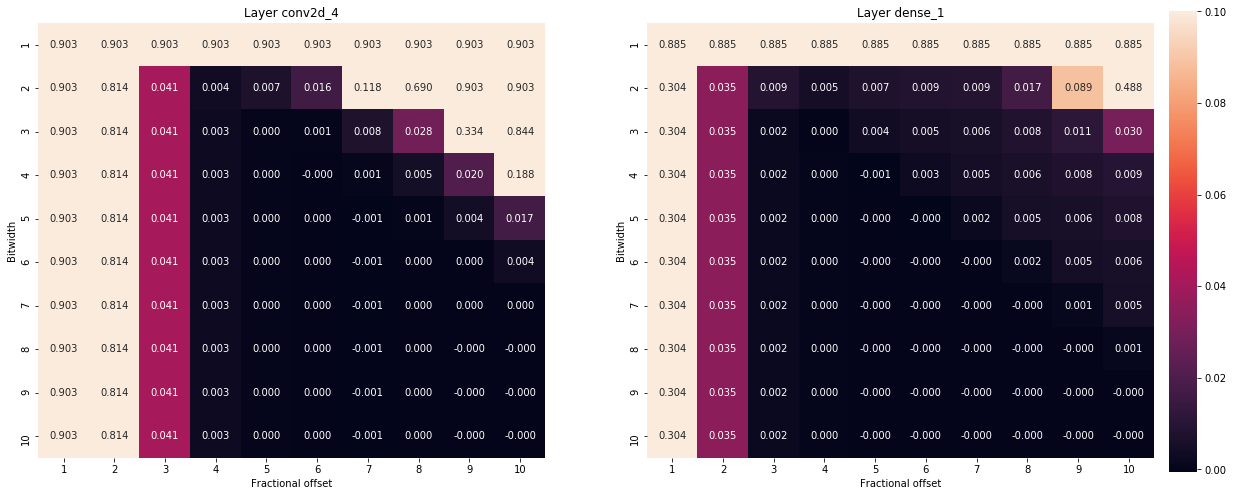

In [25]:
plot_results(scores_3, layer_names[3:], 1, 2, (20, 8), 0.8, bw_range, f_range, vmax=vmax)

C:\Users\320060820\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  after removing the cwd from sys.path.


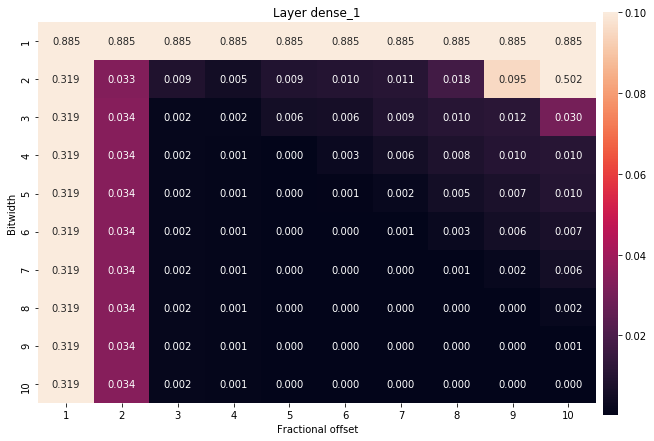

In [27]:
plot_results(scores_4, layer_names[4:], 1, 1, (10, 7), 0.8, bw_range, f_range, vmax=vmax)

#### Visualize weight distribution of final result

In [29]:
keras_mnist.load_model_from_path()
keras_mnist.evaluate_accuracy()[1]

0.9911

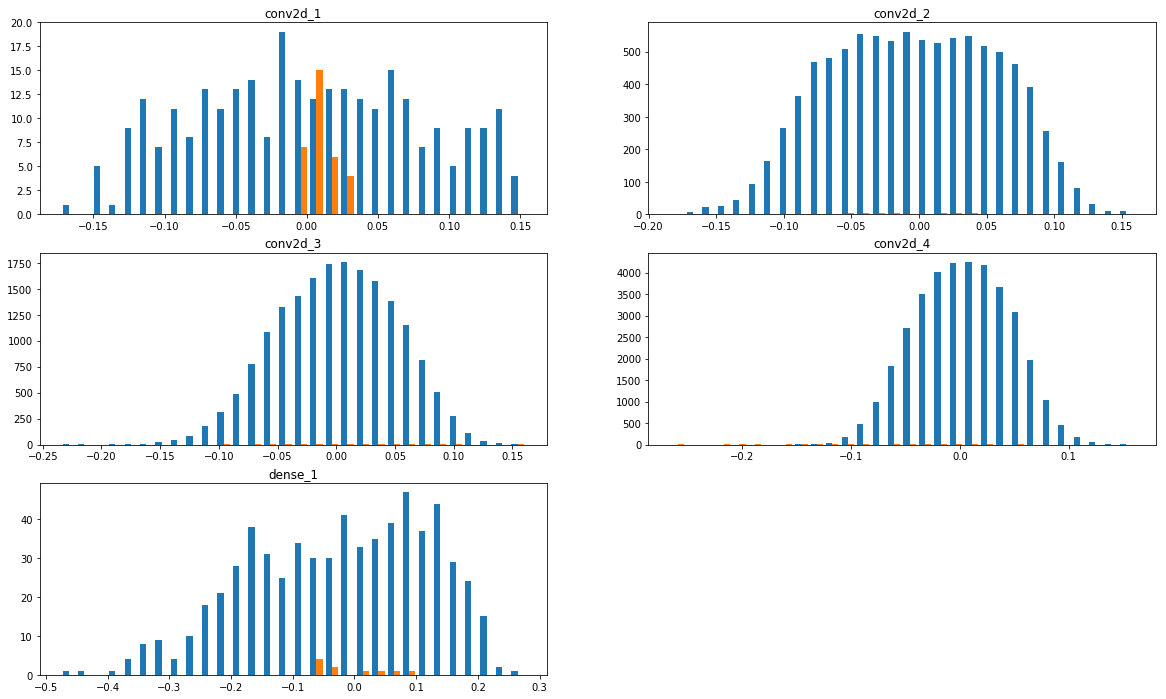

In [30]:
# original set of weights
w = keras_mnist.get_model_weights_by_layer(dense=True)
fig, ax = plt.subplots(3, 2, figsize=(20, 12))
ax = ax.flatten()
for i in range(len(w)):
    ax[i].hist(w[i], bins=30, label=['weights', 'biases']);
    ax[i].set_title(layer_names[i])
fig.delaxes(ax[-1])

In [31]:
parameters = {
    'conv2d_1': [5, 6],
    'conv2d_2': [4, 5],
    'conv2d_3': [3, 4],
    'conv2d_4': [3, 5],
    'dense_1': [3, 4],
}
for k in parameters.keys():
    keras_mnist.model = fxp_quantize.quantize_weights(keras_mnist.model, parameters[k][0], parameters[k][1],
                                                      layer_name=[k])

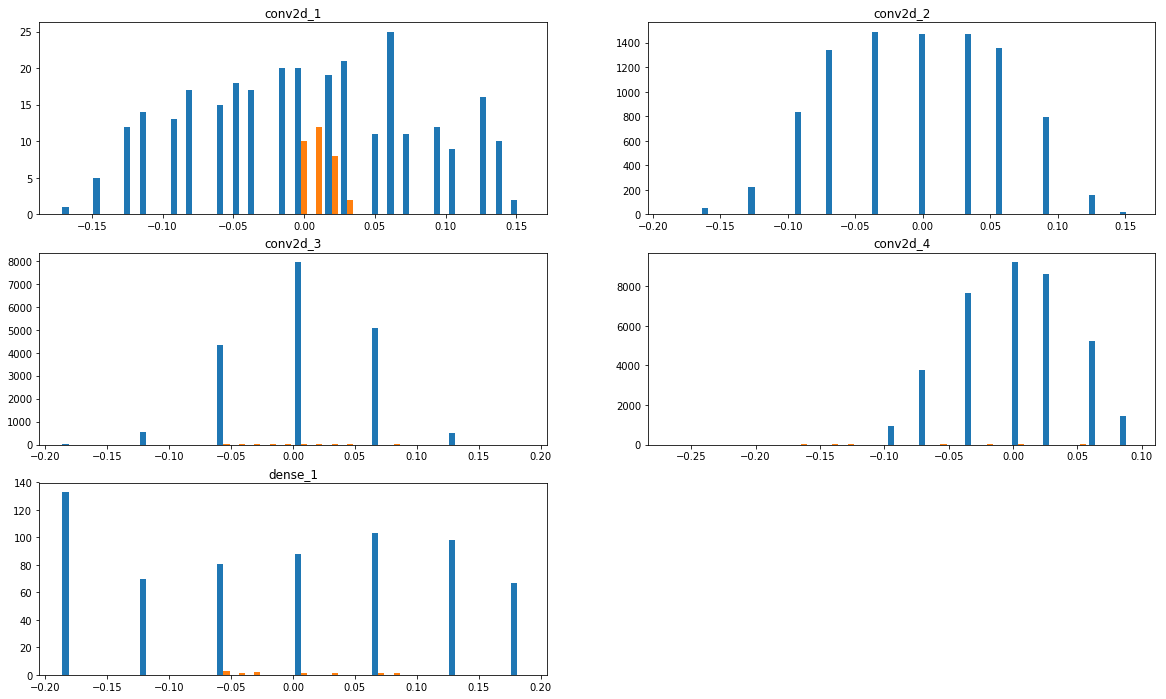

In [32]:
# Quantized set of weights
w = keras_mnist.get_model_weights_by_layer(dense=True)
fig, ax = plt.subplots(3, 2, figsize=(20, 12))
ax = ax.flatten()
for i in range(len(w)):
    ax[i].hist(w[i], bins=30, label=['weights', 'biases']);
    ax[i].set_title(layer_names[i])
fig.delaxes(ax[-1])

In [33]:
keras_mnist.evaluate_accuracy()[1]

0.9896

#### Compare activation distributions before and after quantization

In [43]:
keras_mnist.load_model_from_path()
act_maps_before_quant = keras_mnist.get_activation_maps(keras_mnist.x_test[0].reshape(1, 28, 28, 1), 'conv2d_4')
parameters = {
    'conv2d_1': [5, 6],
    'conv2d_2': [4, 5],
    'conv2d_3': [3, 4],
    'conv2d_4': [3, 5],
    'dense_1': [3, 4],
}
for k in parameters.keys():
    keras_mnist.model = fxp_quantize.quantize_weights(keras_mnist.model, parameters[k][0], parameters[k][1],
                                                      layer_name=[k])

act_maps_after_quant = keras_mnist.get_activation_maps(keras_mnist.x_test[0].reshape(1, 28, 28, 1), 'conv2d_4')

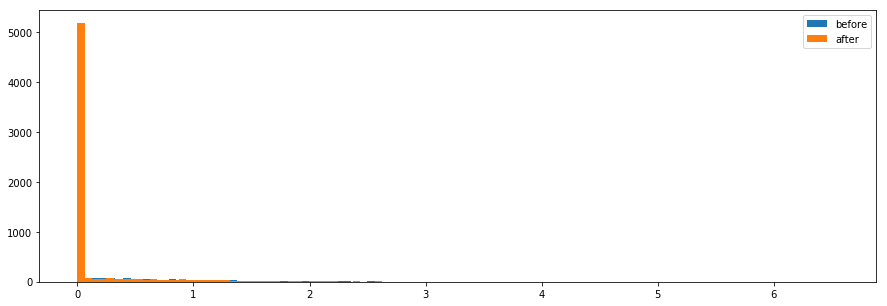

In [44]:
fig = plt.figure(figsize=(15, 5))
plt.hist(act_maps_before_quant.flat, bins=100, label='before');
plt.hist(act_maps_after_quant.flat, bins=100, label='after');
plt.legend()

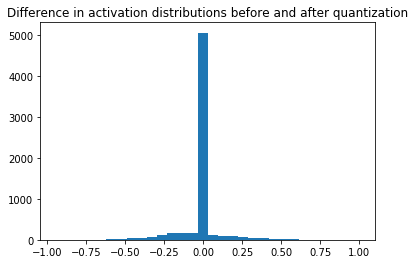

In [45]:
d = act_maps_after_quant - act_maps_before_quant
plt.hist(d.flat, bins=30);
plt.title('Difference in activation distributions before and after quantization');

##### Observations

- Splitting the quantization of weights and biases for MNIST allows us to use harsher quantization for the weights for layer 1. We hence now choose to quantize weights and biases separately for all layers and for all networks/models.  
- After fixing the quantization of a certain layer, and observing the BW and F for the successive layer, we see that the inference accuracy at a given point (BW, F) after fixing quantization for a certain layer, changes as compared to when we quantize that layer while keeping other layers at floating point. This change in inference accuracy values is fairly small if we quantize conservatively. 
- Through experimentation for MNIST, as I was choosing quantization parameters for layer 3, after fixing the quantization for layer 1 and 2, I found that choosing harsher quantization for layer 1 and 2, resulted in worse performance for layer 3 for the same choice of BW_3, F_3 as independent quantization. Essentially, even if layers 1 and 2 allow for harsher quantization with minimal drop in inference accuracy, the bit-widths and fractional offsets must be chosen to be higher in order to minimize inference accuracy drops for the successive layers.
- In comparison to CIFAR10, MNIST allows for harsher quantization of its layers (at least the initial ones). 
- Similar to CIFAR10, we see that harsh quantization of layer 1 leads to unpredictable behaviour for quantization of layer 2 which we would like to avoid. 
- We therefore must quantize conservatively in order to have predictable behaviour for the successive layers, and in order to minimize the drop in inference accuracy.
- The distribution of the weights after quantization will vary given that we apply quantization differently to each layer. 

#### Check differences

Observe the differences in the heatmaps against their independent quantization heatmaps

In [39]:
diff_1_1 = np.abs(scores_[:, :, 1] - scores_1_1[:, :, 0])
diff_1_2 = np.abs(scores_[:, :, 1] - scores_1_2[:, :, 0])
diff_1_3 = np.abs(scores_[:, :, 1] - scores_1_3[:, :, 0])
diff_1_4 = np.abs(scores_[:, :, 1] - scores_1_4[:, :, 0])
diff_2 = np.abs(scores_[:, :, 2] - scores_2[:, :, 0])
diff_3 = np.abs(scores_[:, :, 3] - scores_3[:, :, 0])
diff_4 = np.abs(scores_[:, :, 4] - scores_4)

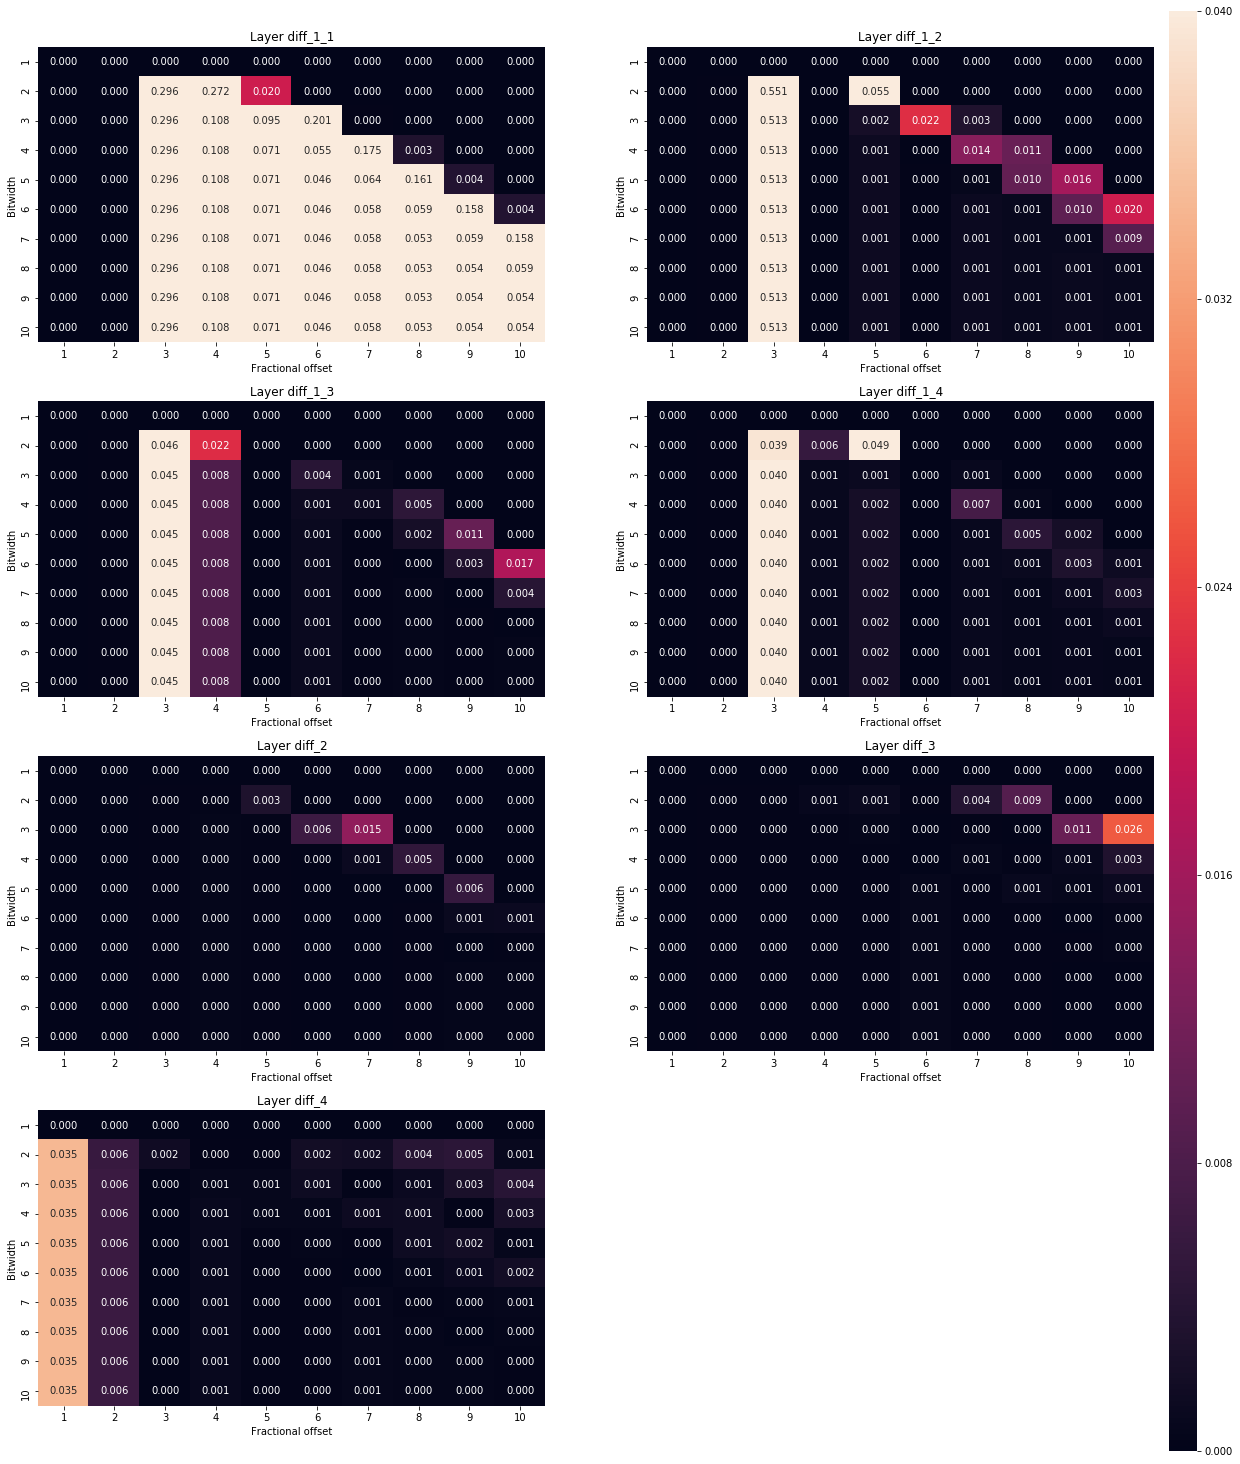

In [40]:
diff = np.dstack((diff_1_1, diff_1_2, diff_1_3, diff_1_4, diff_2, diff_3, diff_4))
names = ['diff_1_1', 'diff_1_2', 'diff_1_3', 'diff_1_4', 'diff_2', 'diff_3', 'diff_4']
plot_results(diff, names, 4, 2, (20, 25), 0.8, bw_range, f_range, vmax=0.04)

### Reverse Quantization

In [46]:
parameters = {
    'dense_1': [3, 4]
}
scores_r1_1 = brute_force_analysis_weights(keras_mnist, layer_names[:-1], bw_range, f_range,
                                   fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_r1_1', arr=scores_r1_1)

parameters = {
    'dense_1': [4, 5]
}
scores_r1_2 = brute_force_analysis_weights(keras_mnist, layer_names[:-1], bw_range, f_range,
                                   fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_r1_2', arr=scores_r1_2)

Layer conv2d_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_4 done.


Layer conv2d_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_4 done.


In [49]:
parameters = {
    'conv2d_4': [3, 5],
    'dense_1': [3, 4]
}
scores_r2 = brute_force_analysis_weights(keras_mnist, layer_names[:-2], bw_range, f_range,
                                   fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_r2', arr=scores_r2)

Layer conv2d_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


In [50]:
parameters = {
    'conv2d_3': [3, 4],
    'conv2d_4': [3, 5],
    'dense_1': [3, 4]
}
scores_r3 = brute_force_analysis_weights(keras_mnist, layer_names[:-3], bw_range, f_range,
                                   fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_r3', arr=scores_r3)

Layer conv2d_1 done.


Layer conv2d_2 done.


In [51]:
parameters = {
    'conv2d_2': [4, 5],
    'conv2d_3': [3, 4],
    'conv2d_4': [3, 5],
    'dense_1': [3, 4]
}
scores_r4 = brute_force_analysis_weights(keras_mnist, layer_names[:-4], bw_range, f_range,
                                   fix_quant=True, parameters=parameters)
np.save(output_path + 'scores_r4', arr=scores_r4)

Layer conv2d_1 done.


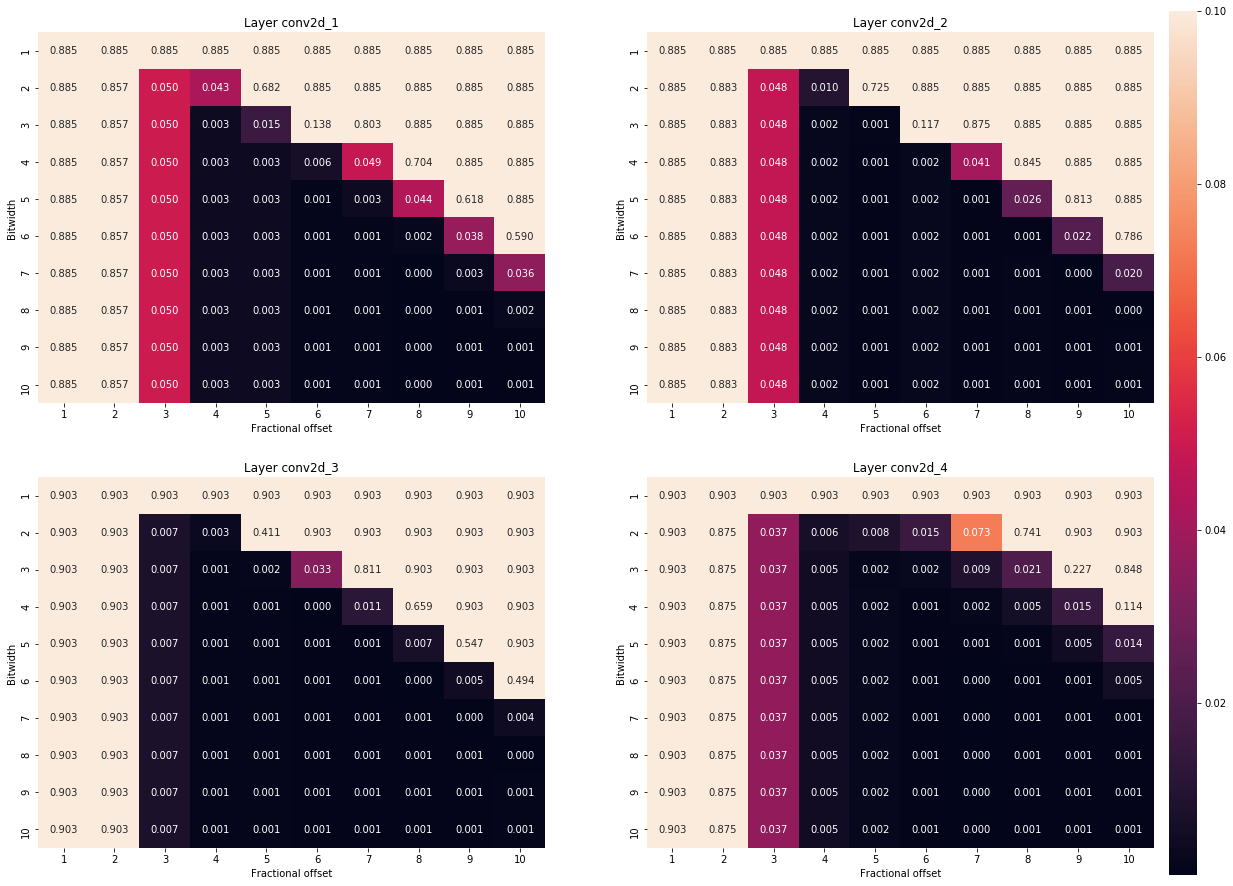

In [47]:
plot_results(scores_r1_1, layer_names[:-1], 2, 2, (20, 15), 0.8, bw_range, f_range, vmax=vmax)

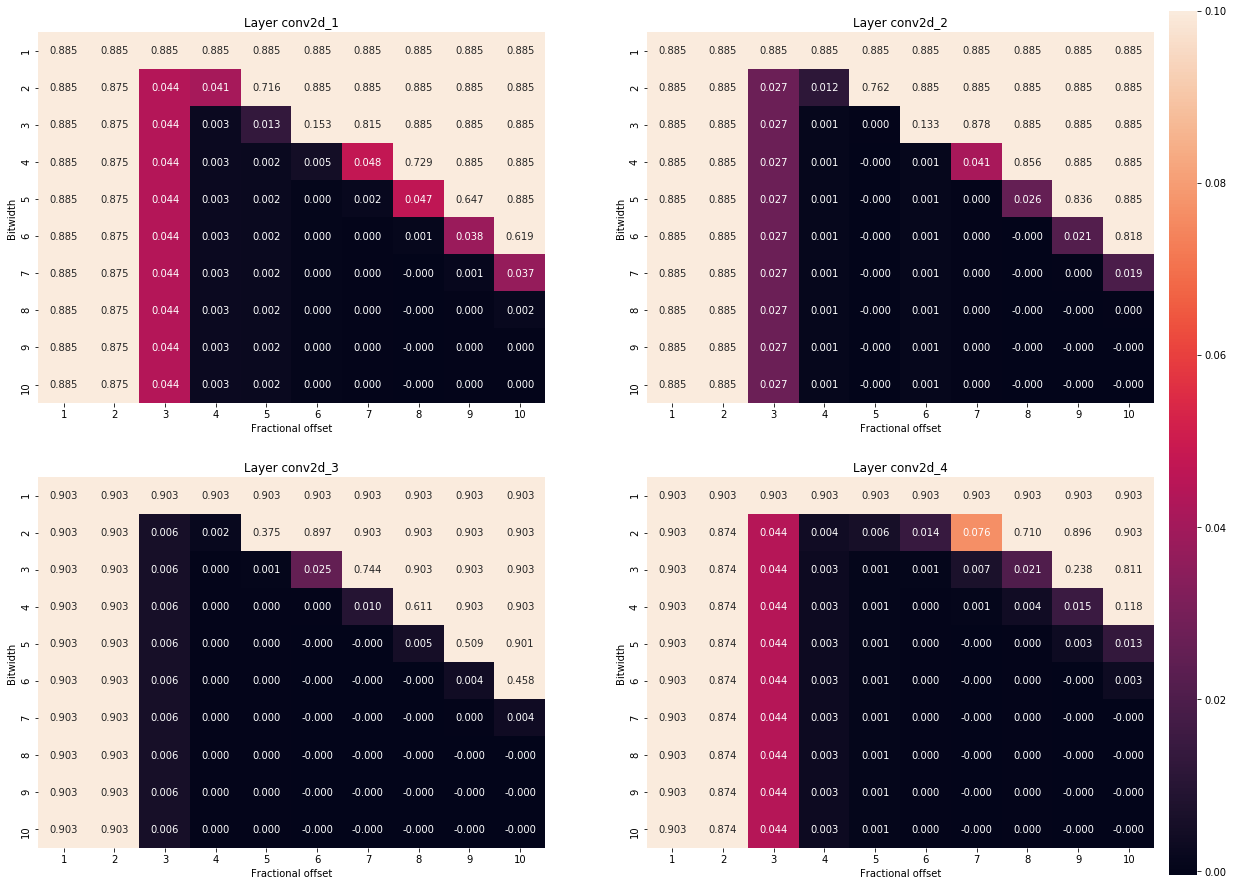

In [48]:
plot_results(scores_r1_2, layer_names[:-1], 2, 2, (20, 15), 0.8, bw_range, f_range, vmax=vmax)

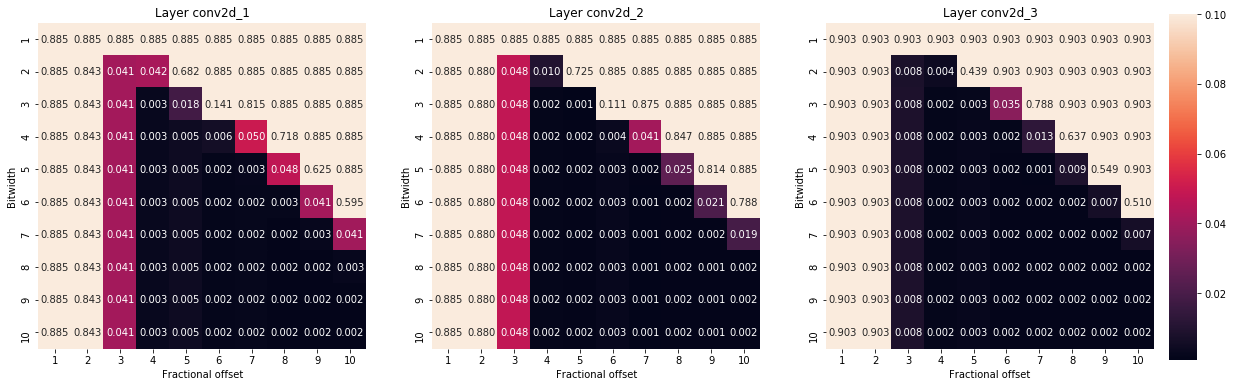

In [52]:
plot_results(scores_r2, layer_names[:-2], 1, 3, (20, 6), 0.8, bw_range, f_range, vmax=vmax)

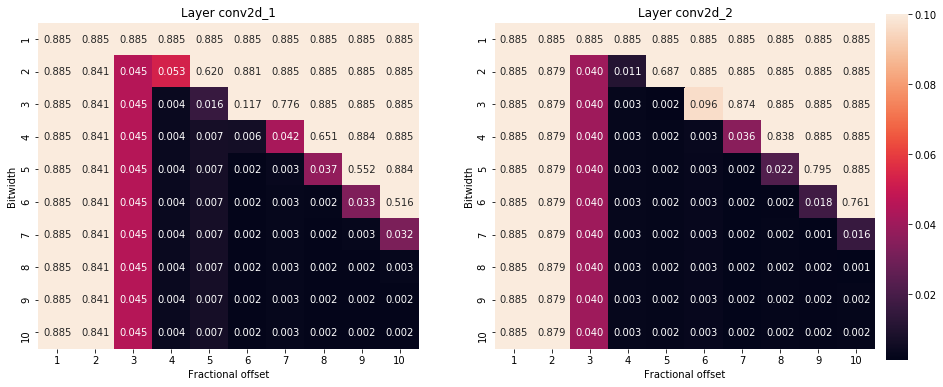

In [53]:
plot_results(scores_r3, layer_names[:-3], 1, 2, (15, 6), 0.8, bw_range, f_range, vmax=vmax)

C:\Users\320060820\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  after removing the cwd from sys.path.


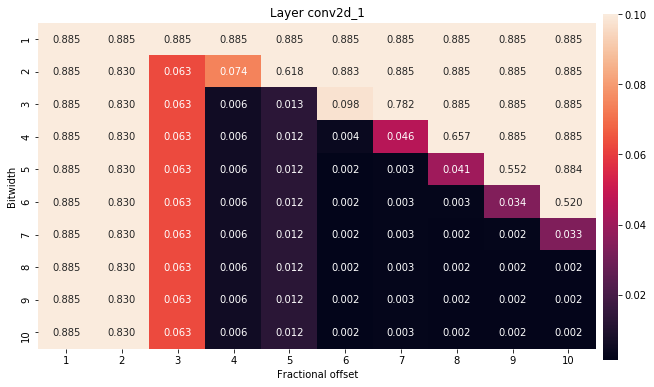

In [54]:
plot_results(scores_r4, layer_names[:-4], 1, 1, (10, 6), 0.8, bw_range, f_range, vmax=vmax)

##### Observations

- After applying reverse quantization, we see that the choice for quantization parameters for layer 1 are still the same as those we would choose independently. This also leads to minimal drop in inference accuracy.
- Clearly, layer 1 is remains to be more sensitive to quantization than the later layers, possibly because it has the least number of parameters to be quantized.
- By applying quantization in reverse, we can see what we observed for scores_1_1-4, wherein, the fractional offset of 5 resulted in worse inference accuracy for successive layers. The reason is not clear. 
- The fractional offset is the main factor that affects the inference accuracy, as long as we have a sufficiently high bit-width for the network.

In [7]:
keras_mnist.load_model_from_path()
print(f'Original floating point model inference accuracy: {keras_mnist.evaluate_accuracy()[1]}')

w_quant_params = {
    'conv2d_1': [5, 6],
    'conv2d_2': [4, 5],
    'conv2d_3': [3, 4],
    'conv2d_4': [3, 5],
    'dense_1': [3, 4],
}
keras_mnist = fix_weights_quantization(keras_mnist, w_quant_params)

print(f'Fixed-point quantized weights model inference accuracy: {keras_mnist.evaluate_accuracy()[1]}')

Original floating point model inference accuracy: 0.9911
Fixed-point quantized weights model inference accuracy: 0.9896


## Quantizing Biases

In [8]:
def fix_biases_quantization(model, parameters):
    
    for k in parameters.keys():
        model.model = fxp_quantize.quantize_biases(model.model, parameters[k][0], parameters[k][1],
                                                   layer_name=[k])
    return model


def brute_force_analysis_biases(model, layer_names, bw_range, f_range, fix_w_quant=False, w_parameters=None,
                                fix_b_quant=False, b_parameters=None, eval_metric='acc_drop'):
    
    if (fix_w_quant and w_parameters is None) or (fix_b_quant and b_parameters is None):
        raise ValueError('Parameters is empty')
    
    if not isinstance(layer_names, list):
        layer_names = [layer_names]
    
    for i in layer_names:

        scores_matrix = []

        for j in tnrange(len(bw_range), desc=f'BW Layer {i}', leave=False):
            scores_row = []
            
            for k in tqdm_notebook(range(len(f_range)), desc='F', leave=False):

                model.load_model_from_path()

                if fix_w_quant:
                    model = fix_weights_quantization(model, w_parameters)
                    
                if fix_b_quant:
                    model = fix_biases_quantization(model, b_parameters)

                model.model = fxp_quantize.quantize_biases(model.model, bw_range[j], f_range[k],
                                                            layer_name=[i])
                scores_row.append(model.evaluate_accuracy()[1])

            scores_matrix.append(scores_row)

        scores = np.array(scores_matrix)

        if layer_names.index(i) == 0:
            model_scores = scores
        else:
            model_scores = np.dstack((model_scores, scores))
        
        print(f'Layer {i} done.')
        
    model.load_model_from_path()
    s = model.evaluate_accuracy()[1]
    
    if eval_metric == 'acc_drop':
        model_scores = (s - model_scores) / s
        
    elif eval_metric == 'acc_ratio':
        model_scores = model_scores / s
        
    elif eval_metric == 'quant_acc':
        pass
        
    return model_scores

In [10]:
scores_b_1 = brute_force_analysis_biases(keras_mnist, layer_names, bw_range, f_range, 
                                         fix_w_quant=True, w_parameters=w_quant_params)

Layer conv2d_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_4 done.


Layer dense_1 done.


In [11]:
np.save(output_path + 'scores_b_1', arr=scores_b_1)

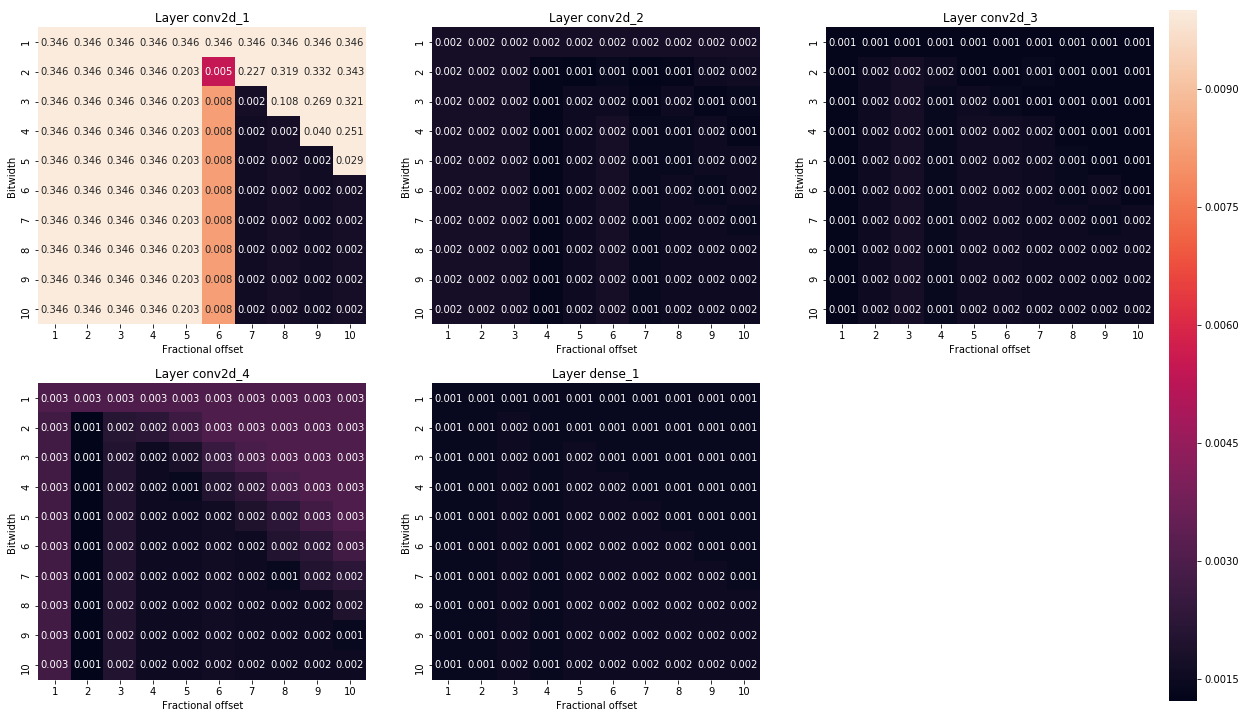

In [12]:
plot_results(scores_b_1, layer_names, 2, 3, (20, 12), 0.8, bw_range, f_range, vmax=0.01)

In [13]:
b_quant_params = {
    'conv2d_1': [3, 7],
}
scores_b_2 = brute_force_analysis_biases(keras_mnist, layer_names[1:], bw_range, f_range,
                                         fix_w_quant=True, w_parameters=w_quant_params,
                                         fix_b_quant=True, b_parameters=b_quant_params)

Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_4 done.


Layer dense_1 done.


In [14]:
np.save(output_path + 'scores_b_2', arr=scores_b_2)

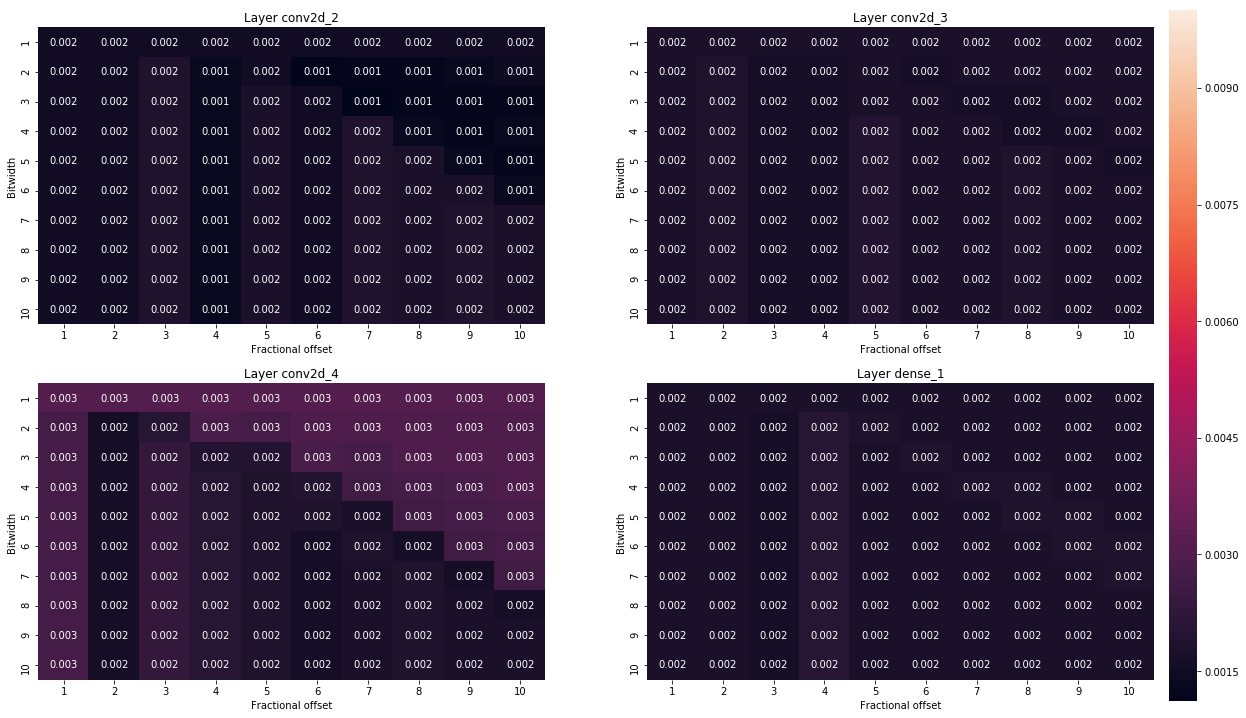

In [15]:
plot_results(scores_b_2, layer_names[1:], 2, 2, (20, 12), 0.8, bw_range, f_range, vmax=0.01)

In [16]:
b_quant_params = {
    'conv2d_1': [3, 7],
    'conv2d_2': [2, 4]
}
scores_b_3 = brute_force_analysis_biases(keras_mnist, layer_names[2:], bw_range, f_range,
                                         fix_w_quant=True, w_parameters=w_quant_params,
                                         fix_b_quant=True, b_parameters=b_quant_params)

Layer conv2d_3 done.


Layer conv2d_4 done.


Layer dense_1 done.


In [17]:
np.save(output_path + 'scores_b_3', arr=scores_b_3)

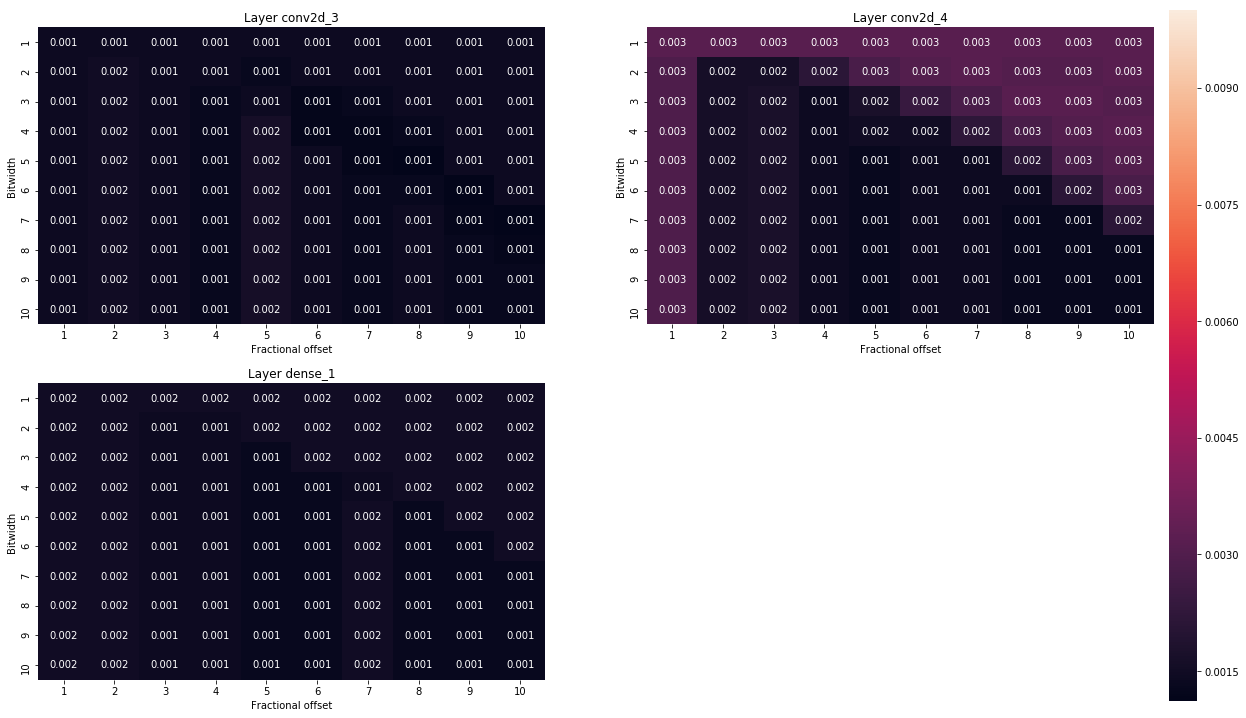

In [18]:
plot_results(scores_b_3, layer_names[2:], 2, 2, (20, 12), 0.8, bw_range, f_range, vmax=0.01)

In [19]:
b_quant_params = {
    'conv2d_1': [3, 7],
    'conv2d_2': [2, 4],
    'conv2d_3': [1, 1]
}
scores_b_4 = brute_force_analysis_biases(keras_mnist, layer_names[3:], bw_range, f_range,
                                         fix_w_quant=True, w_parameters=w_quant_params,
                                         fix_b_quant=True, b_parameters=b_quant_params)
np.save(output_path + 'scores_b_4', arr=scores_b_4)

Layer conv2d_4 done.


Layer dense_1 done.


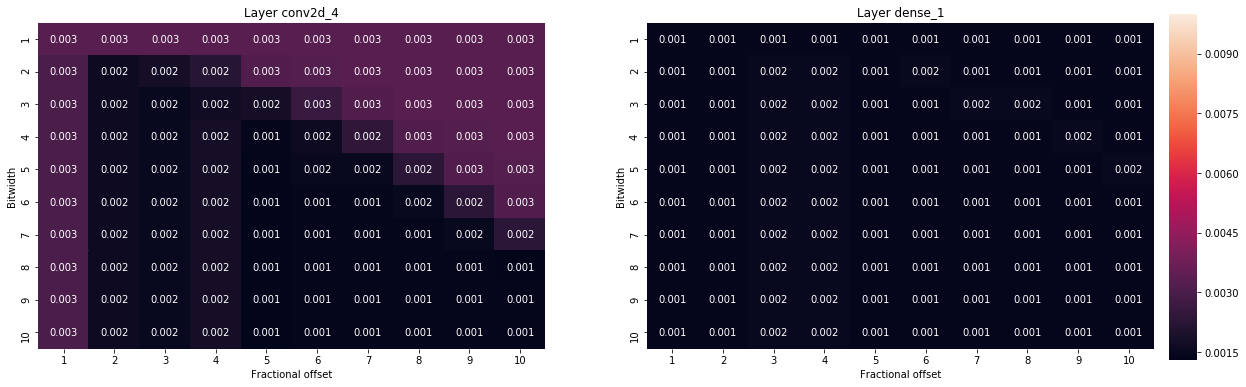

In [20]:
plot_results(scores_b_4, layer_names[3:], 1, 2, (20, 6), 0.8, bw_range, f_range, vmax=0.01)